In [1]:
##################################################
## Imports Versions
##################################################
from platform import python_version
import tensorflow as tf
import librosa as lb
import audiomentations as augs
import diskcache as dc
import functools
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import datetime
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import warnings
warnings.filterwarnings("ignore") #ignore warnings

##################################################
import data_loader_cache as dlc

# print system information
print('Python Version           : ', python_version())
print('TensorFlow Version       : ', tf.__version__)
print('Librosa Version          : ', lb.__version__)
print('Audiomentations Version  : ', augs.__version__)


Python Version           :  3.10.12
TensorFlow Version       :  2.17.0
Librosa Version          :  0.10.2.post1
Audiomentations Version  :  0.37.0


# Audio Augmentations
Augmentation is done to both expand the size and diversity of the dataset. it will help adding variations to the original data to increase the robustness of the model and to increase generalization to unseen data. 

In context of Project Echo, augmentation to our audio dataset can include pitch shift, adding noise, or shifting the sound.Although we have a really big pool of data samples of the animal sounds, the species classes are a lot as well. Thus adding augmentation might help in increasing the data pool for each species, thus enabling the model to recognise more features. 

## Previous Research

There are several research that has been done using audio augmentations, which results in enhanced recognition accuracy such as:

1. Audio augmentation for speech recognition (Ko et.al., 2015). This research implements speech pertubation technique and compare it to existing Vocal Length Pertubation (VTLP) augmentation technique which shows speech pertubation of the training data leads to relative improvement of 2%.

2. Data Augmentation and Deep Learning Methods in Sound Classification: A Systematic Review (Abayomi-Alli et.al., 2022) This paper also analyzed various other research regarding audio data augmentation, where it shows that pitch stretching, time shift, noise additions are most commonly used for mel-frequency cepstral coefficients (MFCC) which tends to show good results


### Reference

- Ko, T., Peddinti, V., Povey, D., & Khudanpur, S. (2015, September). Audio augmentation for speech recognition. In Interspeech (Vol. 2015, p. 3586).
- Abayomi-Alli, Olusola O., Robertas Damaševičius, Atika Qazi, Mariam Adedoyin-Olowe, and Sanjay Misra. 2022. "Data Augmentation and Deep Learning Methods in Sound Classification: A Systematic Review" Electronics 11, no. 22: 3795. https://doi.org/10.3390/electronics11223795

# Data Loading

In [60]:
# create the dataset
if dlc.SC['USE_DISK_CACHE']:
    cache = dc.Cache(dlc.SC['CACHE_DIRETORY'], cull_limit=0, size_limit=10**9) 
# enforce max 5GB memory on GPU for this notebook if you have a small GPU
dlc.enforce_memory_limit(5120)


train_ds, val_ds, test_ds, class_names = dlc.create_datasets(dlc.SC['AUDIO_DATA_DIRECTORY'],train_split=0.8, val_split=0.19)
print("Class names: ", class_names)
print("Number of classes: ", len(class_names))
print(f"Training   dataset length: {len(train_ds)}")
print(f"Validation dataset length: {len(val_ds)}")
print(f"Test       dataset length: {len(test_ds)}")

Class names:  ['Acanthiza chrysorrhoa', 'Acanthiza lineata', 'Acanthiza nana', 'Acanthiza pusilla', 'Acanthiza reguloides', 'Acanthiza uropygialis', 'Acanthorhynchus tenuirostris', 'Accipiter cirrocephalus', 'Aidemosyne modesta', 'Alauda arvensis', 'Anhinga novaehollandiae', 'Anthochaera phrygia', 'Antigone rubicunda', 'Artamus cinereus', 'Artamus cyanopterus', 'Artamus minor', 'Artamus superciliosus', 'Barnardius zonarius', 'Callocephalon fimbriatum', 'Calyptorhynchus banksii', 'Calyptorhynchus lathami', 'Capra Hircus', 'Carduelis carduelis', 'Carterornis leucotis', 'Cervus Unicolour', 'Ceyx azureus', 'Chenonetta jubata', 'Chlamydera nuchalis', 'Cincloramphus mathewsi', 'Cinclosoma punctatum', 'Cisticola exilis', 'Climacteris picumnus', 'Colluricincla harmonica', 'Conopophila albogularis', 'Cophixalus exiguus', 'Cophixalus infacetus', 'Cophixalus ornatus', 'Coracina novaehollandiae', 'Coracina papuensis', 'Corcorax melanorhamphos', 'Cormobates leucophaea', 'Corvus mellori', 'Coturnix 

In [61]:
len_train_ds = len(train_ds)
parallel_calls = tf.data.AUTOTUNE
cache_output_types = (tf.string,tf.float32,tf.int32,tf.string,tf.int32)
procs_output_types = (tf.float32,tf.float32,tf.int32,tf.string,tf.int32)

In [4]:
import data_loader_cache as dlc
train_dataset = (train_ds
                .shuffle(len_train_ds)
                .map(dlc.tensorflow_add_variant_and_cache, num_parallel_calls=parallel_calls)
                .map(functools.partial(dlc.python_fuction_wrapper, dlc.python_disk_cache_start, cache_output_types), num_parallel_calls=parallel_calls)
                .map(functools.partial(dlc.python_fuction_wrapper, dlc.python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
                .map(dlc.tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
                # .map(functools.partial(python_fuction_wrapper, python_audio_augmentations, procs_output_types), num_parallel_calls=parallel_calls)
                .map(functools.partial(dlc.python_fuction_wrapper, dlc.python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
                .map(dlc.tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
                # .map(tensorflow_image_augmentations, num_parallel_calls=parallel_calls)
                .map(functools.partial(dlc.python_fuction_wrapper, dlc.python_disk_cache_end, procs_output_types), num_parallel_calls=parallel_calls)
                .map(dlc.tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
                .map(dlc.tensorflow_drop_variant_and_cache, num_parallel_calls=parallel_calls)
                .batch(dlc.SC['CLASSIFIER_BATCH_SIZE'])
                .prefetch(parallel_calls)
                .repeat(count=1)
)

In [21]:
val_dataset = (val_ds
                    .map(dlc.tensorflow_add_variant_and_cache, num_parallel_calls=parallel_calls)
                    .map(functools.partial(dlc.python_fuction_wrapper, dlc.python_disk_cache_start, cache_output_types), num_parallel_calls=parallel_calls)
                    .map(functools.partial(dlc.python_fuction_wrapper, dlc.python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
                    .map(dlc.tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
                    .map(functools.partial(dlc.python_fuction_wrapper, dlc.python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
                    .map(dlc.tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
                    .map(dlc.tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
                    .map(functools.partial(dlc.python_fuction_wrapper, dlc.python_disk_cache_end, procs_output_types), num_parallel_calls=parallel_calls)
                    .map(dlc.tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
                    .map(dlc.tensorflow_drop_variant_and_cache, num_parallel_calls=parallel_calls)
                    .batch(dlc.SC['CLASSIFIER_BATCH_SIZE'])
                    .prefetch(parallel_calls)
                    .repeat(count=1)
)

In [62]:
test_dataset = (test_ds
                .map(dlc.tensorflow_add_variant_and_cache, num_parallel_calls=parallel_calls)
                .map(functools.partial(dlc.python_fuction_wrapper, dlc.python_disk_cache_start, cache_output_types), num_parallel_calls=parallel_calls)
                .map(functools.partial(dlc.python_fuction_wrapper, dlc.python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
                .map(dlc.tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
                .map(functools.partial(dlc.python_fuction_wrapper, dlc.python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
                .map(dlc.tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
                .map(dlc.tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
                .map(functools.partial(dlc.python_fuction_wrapper, dlc.python_disk_cache_end, procs_output_types), num_parallel_calls=parallel_calls)
                .map(dlc.tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
                .map(dlc.tensorflow_drop_variant_and_cache, num_parallel_calls=parallel_calls)
                .batch(dlc.SC['CLASSIFIER_BATCH_SIZE'])
                .prefetch(parallel_calls)
                .repeat(count=1)
)

 sample info: (16, 260, 260, 3), 
 label info: (16, 118) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


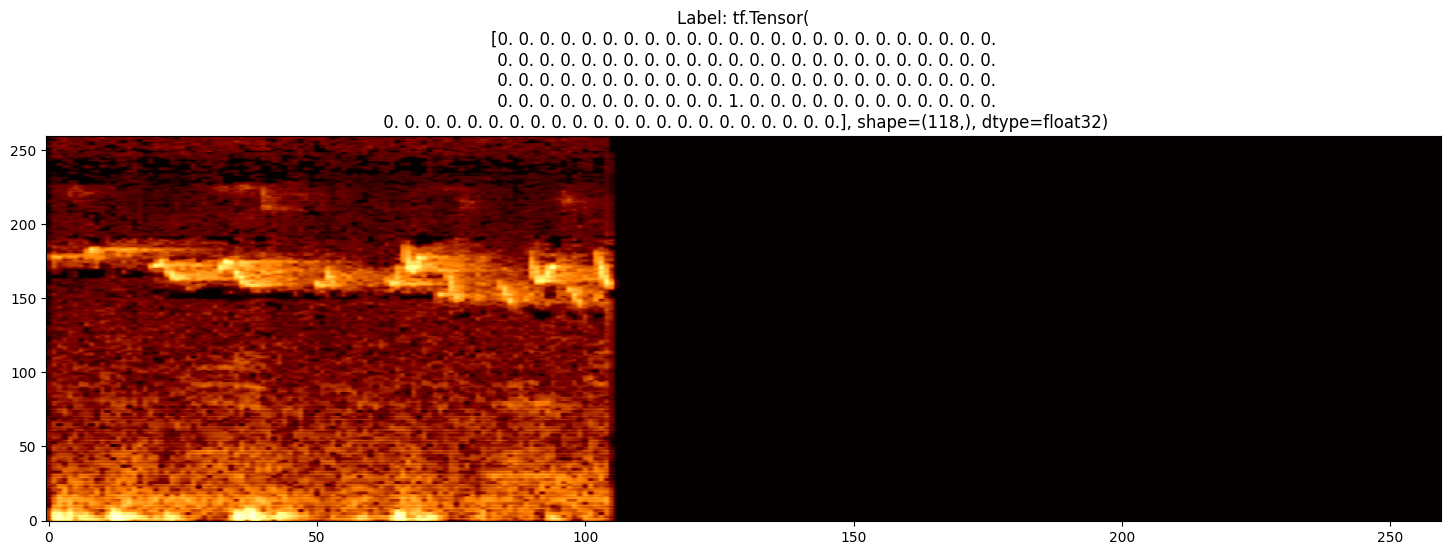

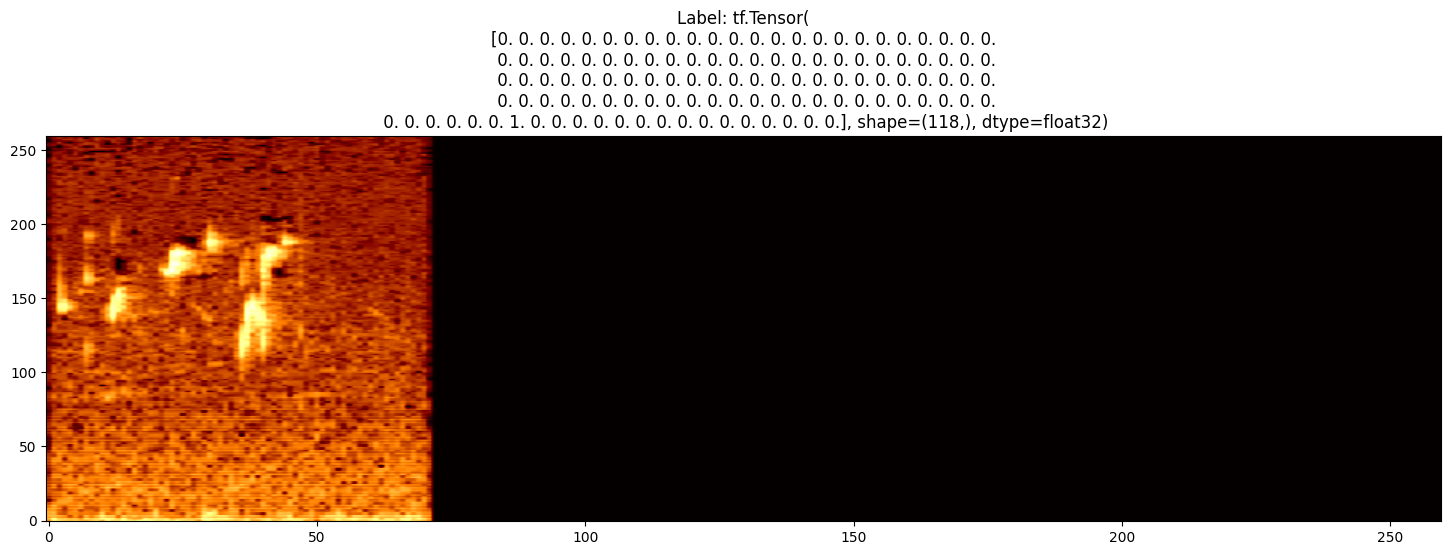

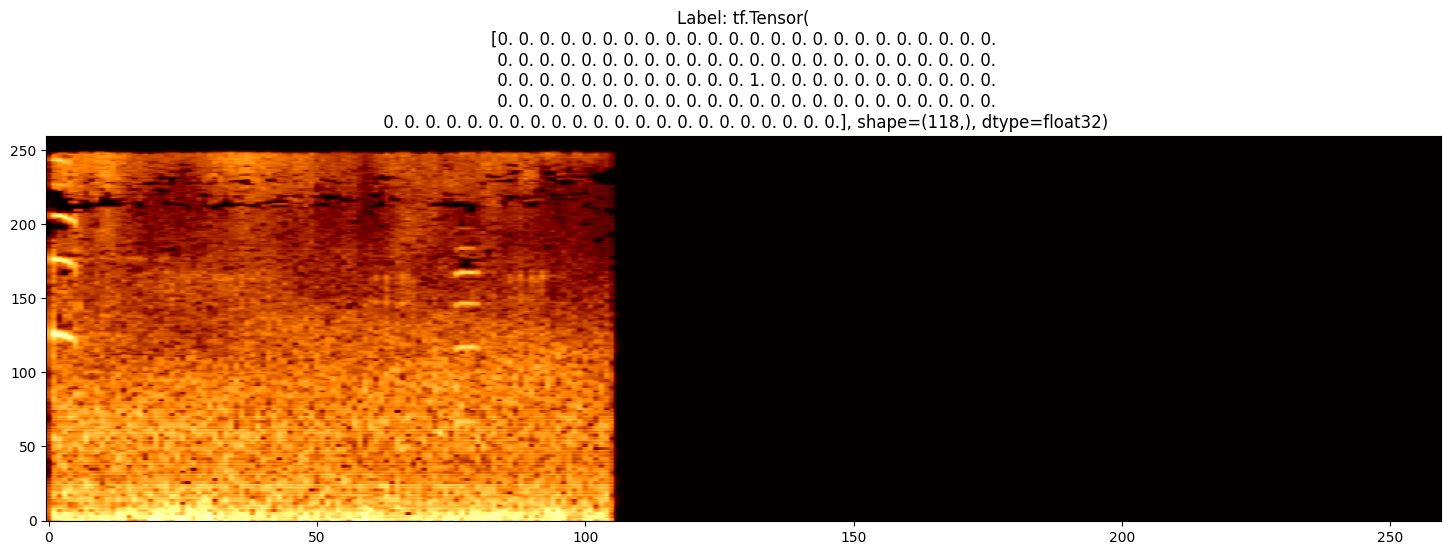

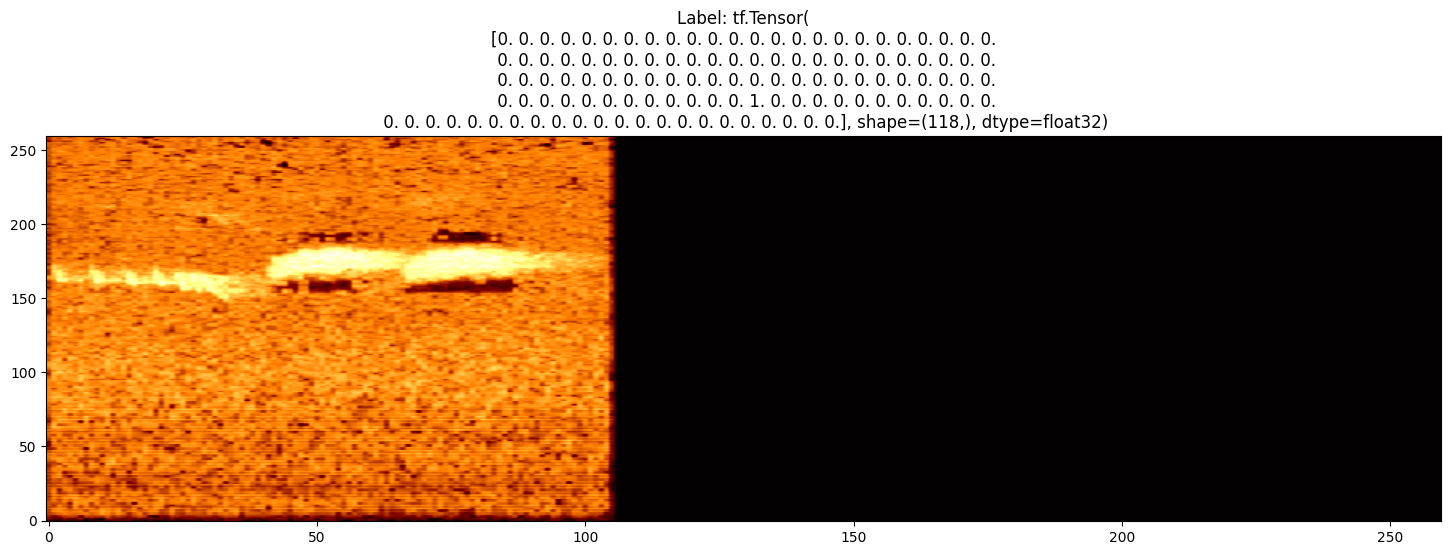

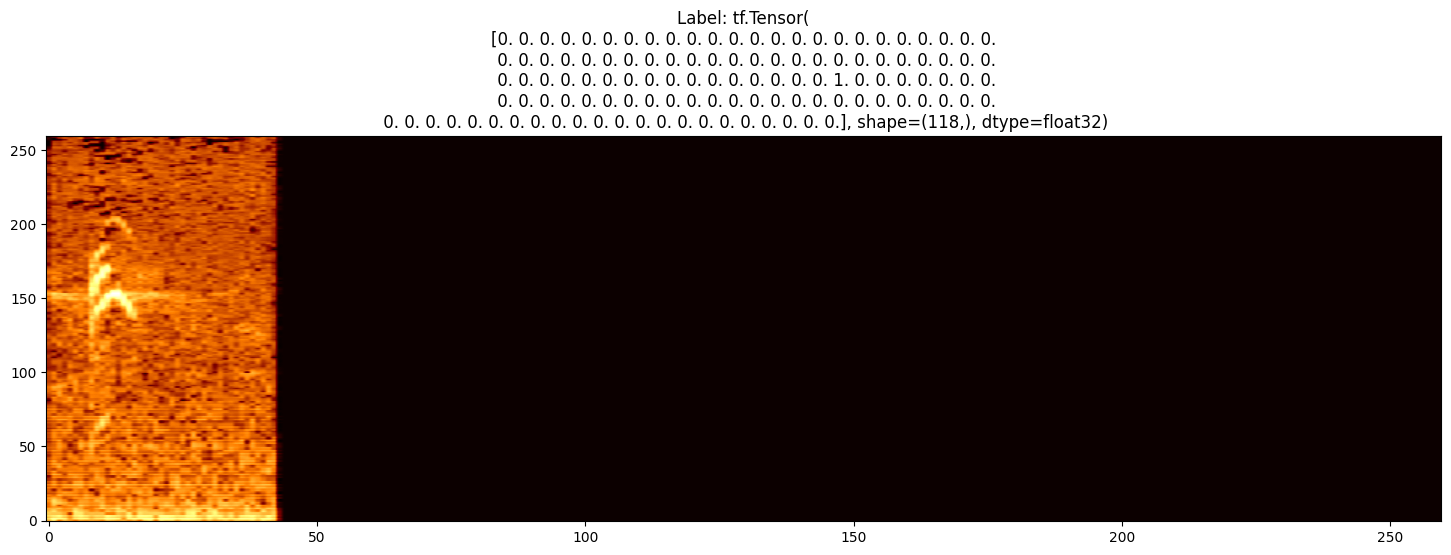

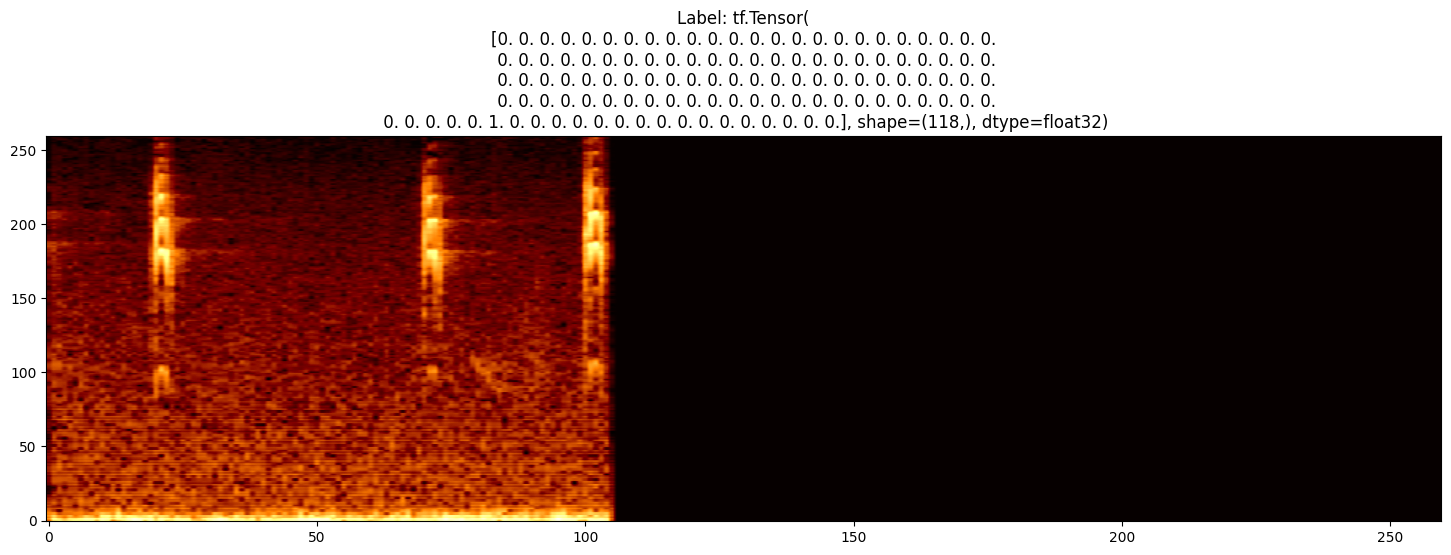

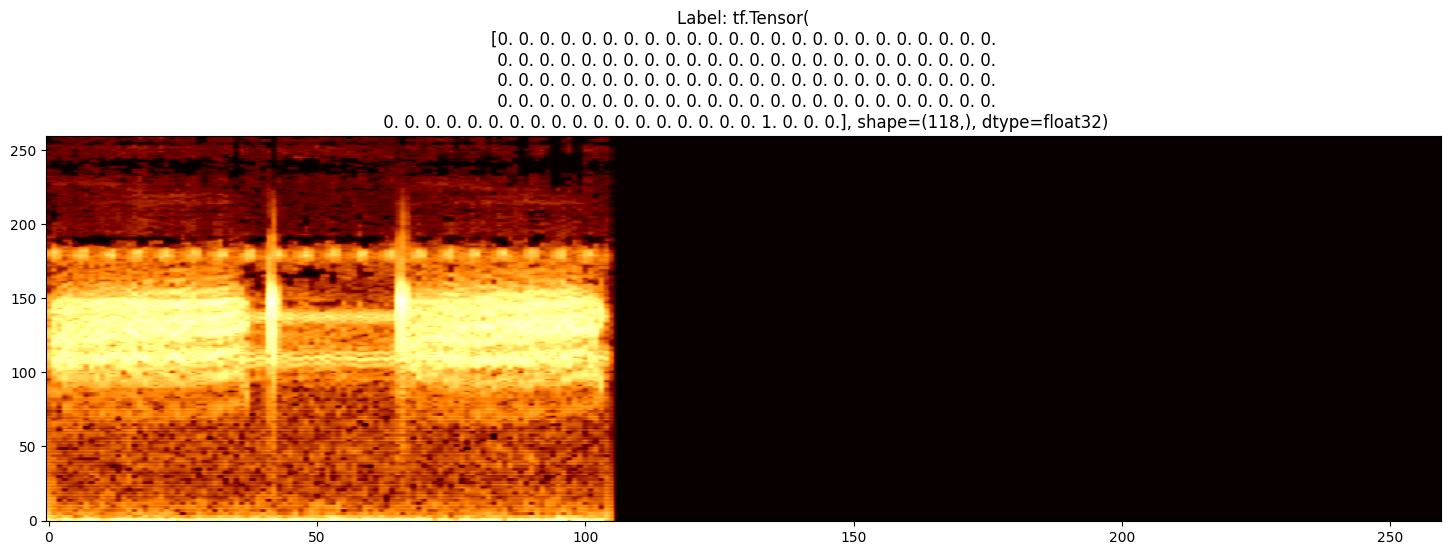

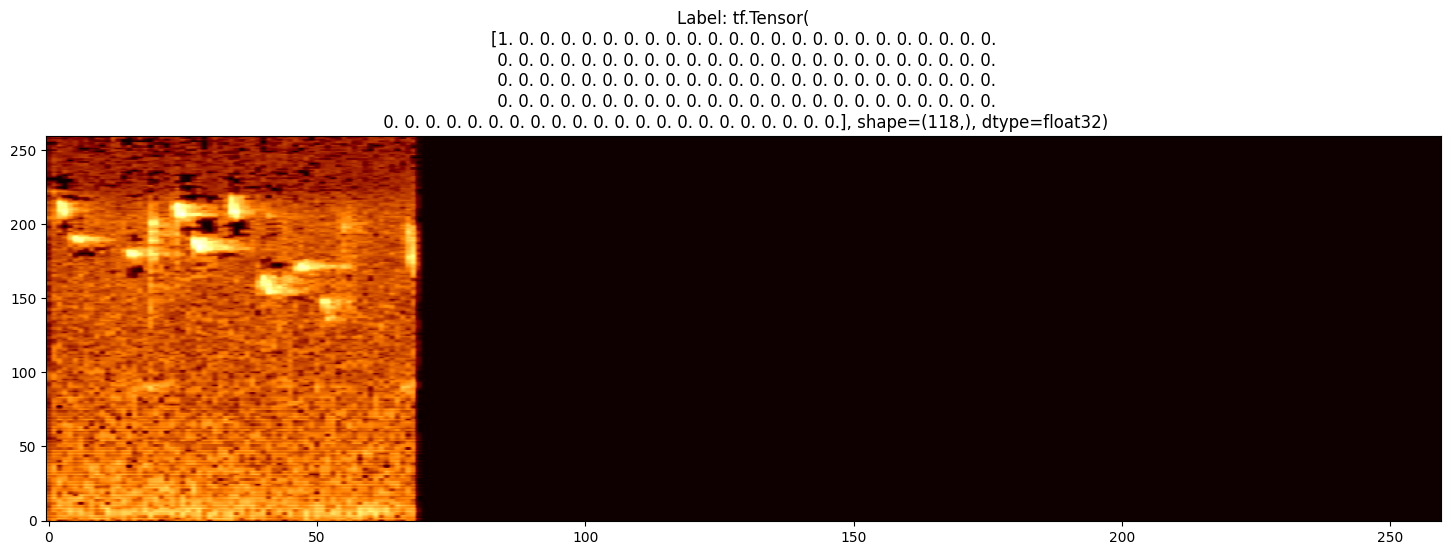

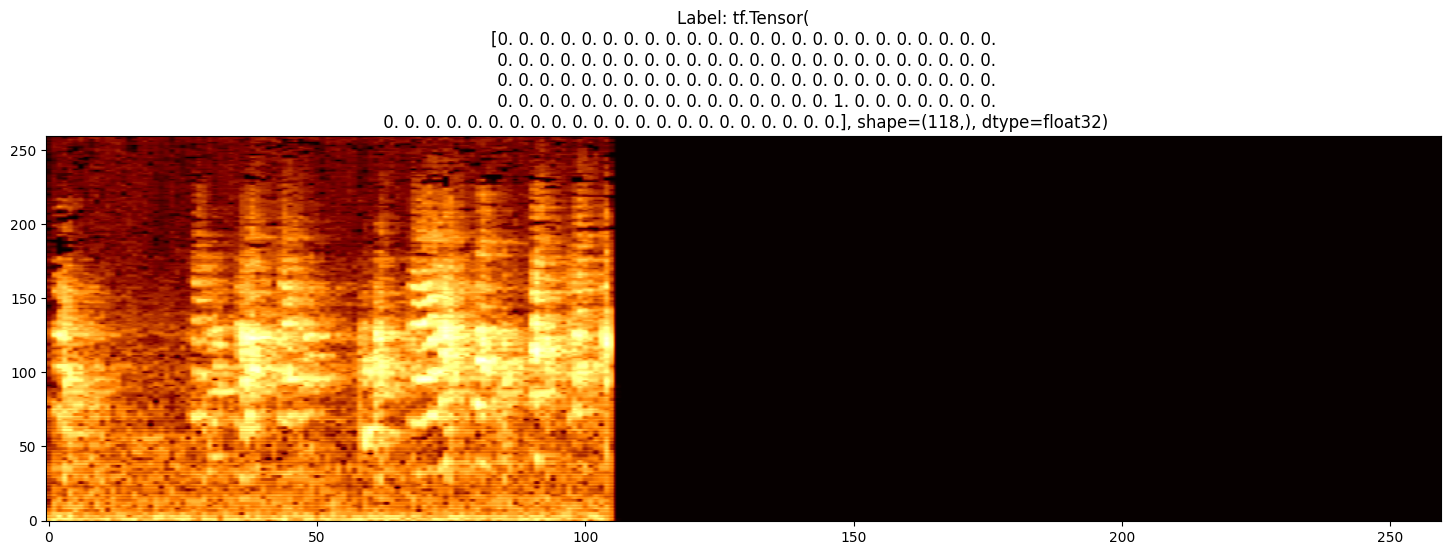

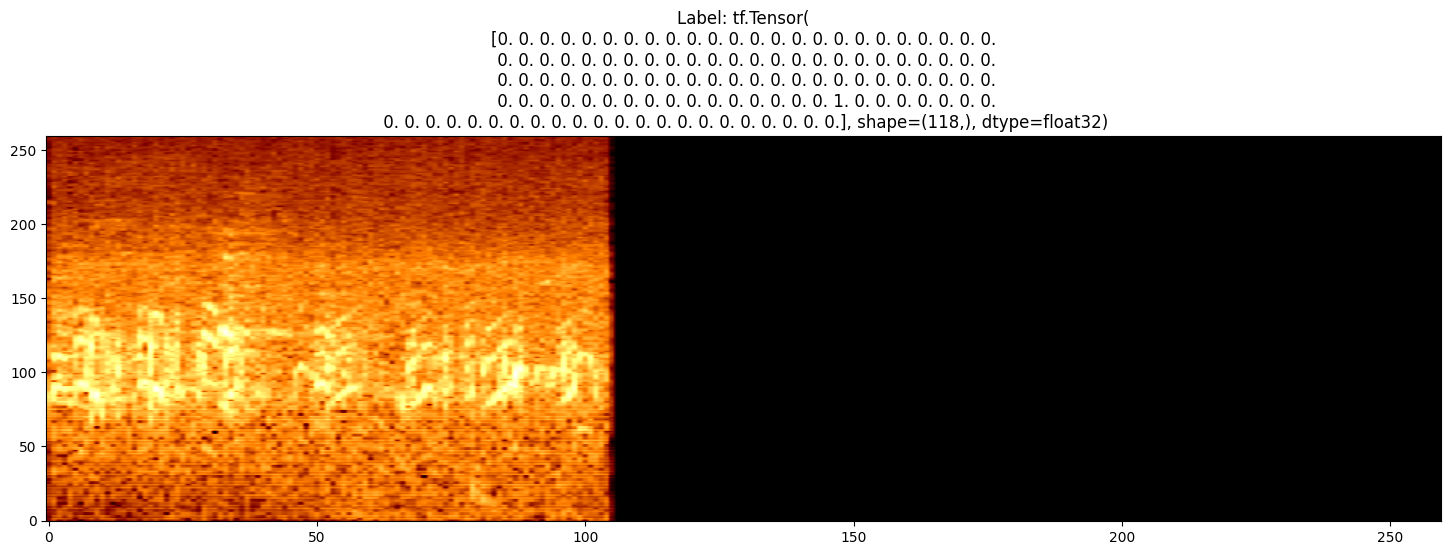

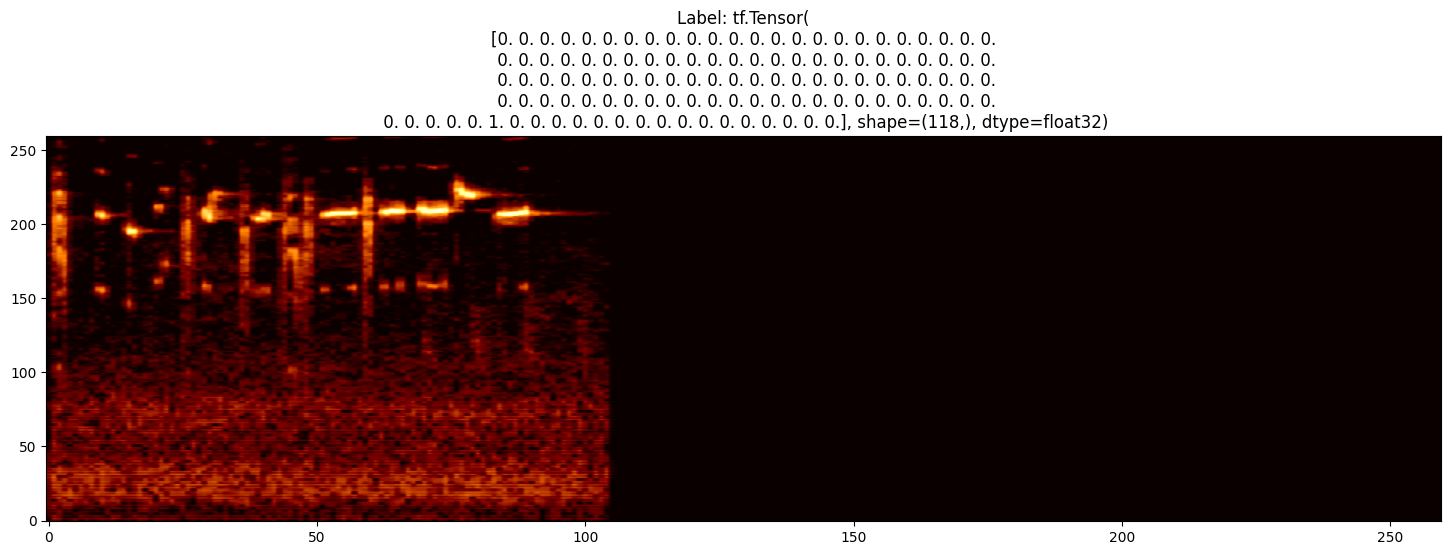

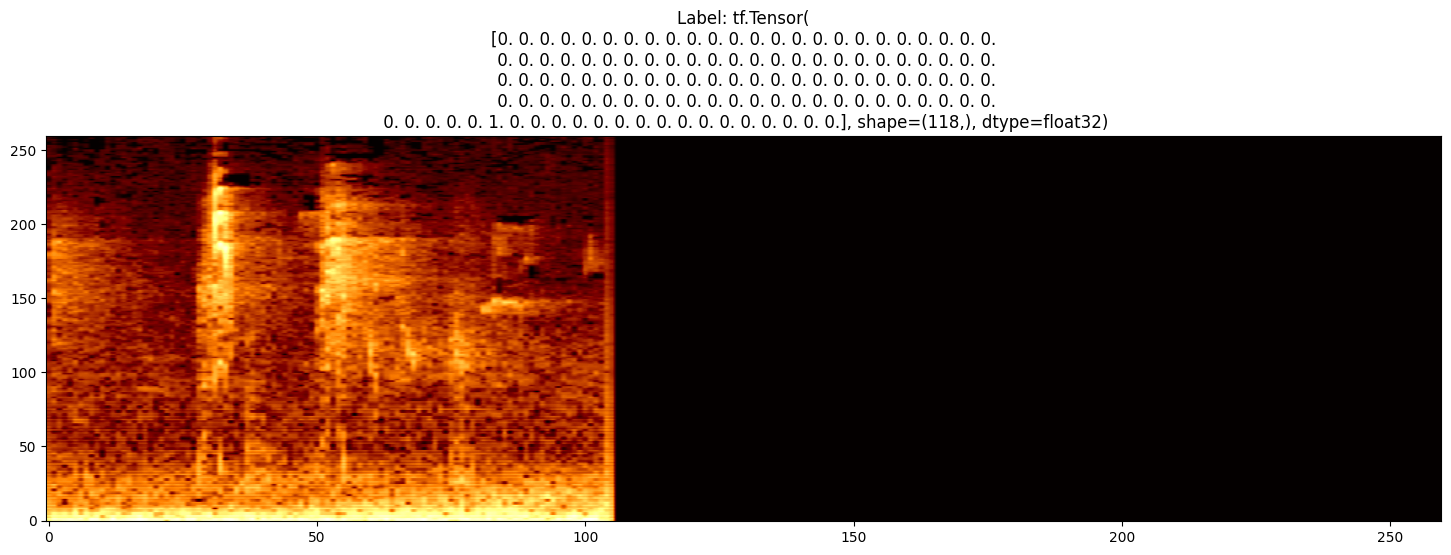

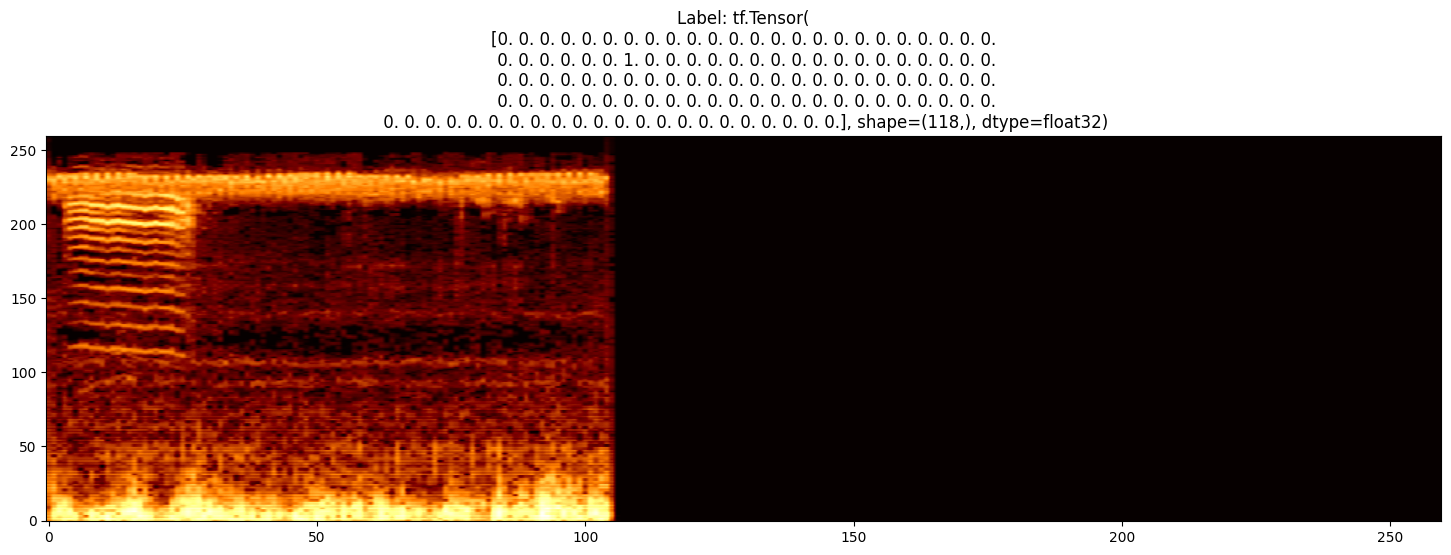

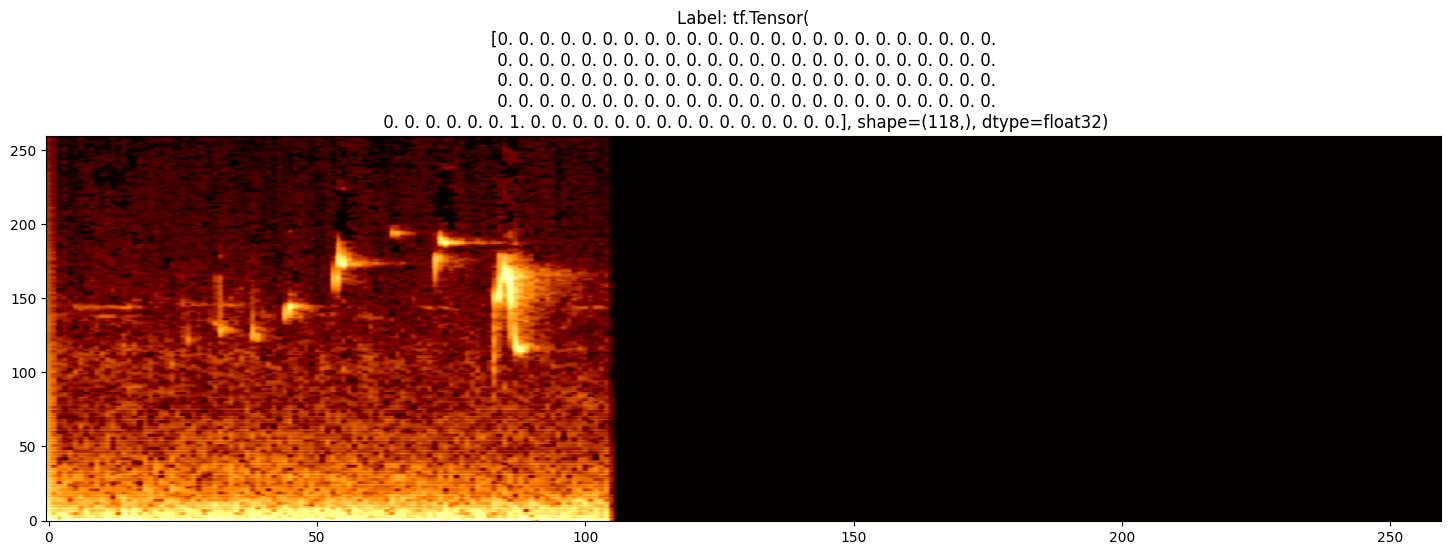

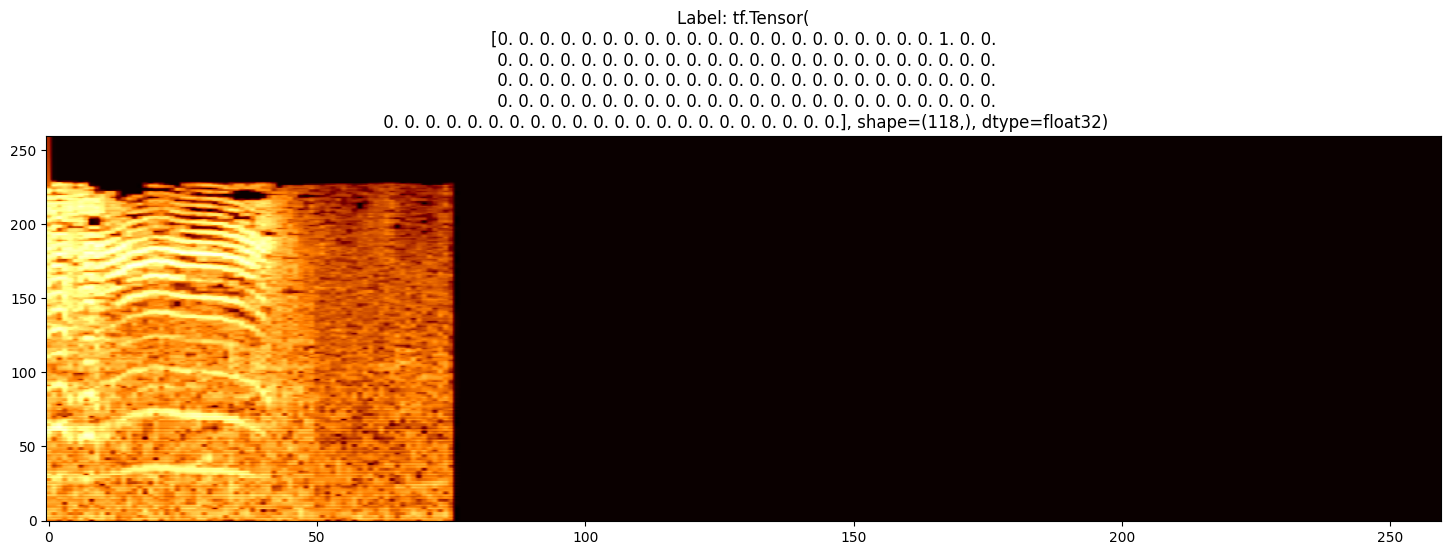

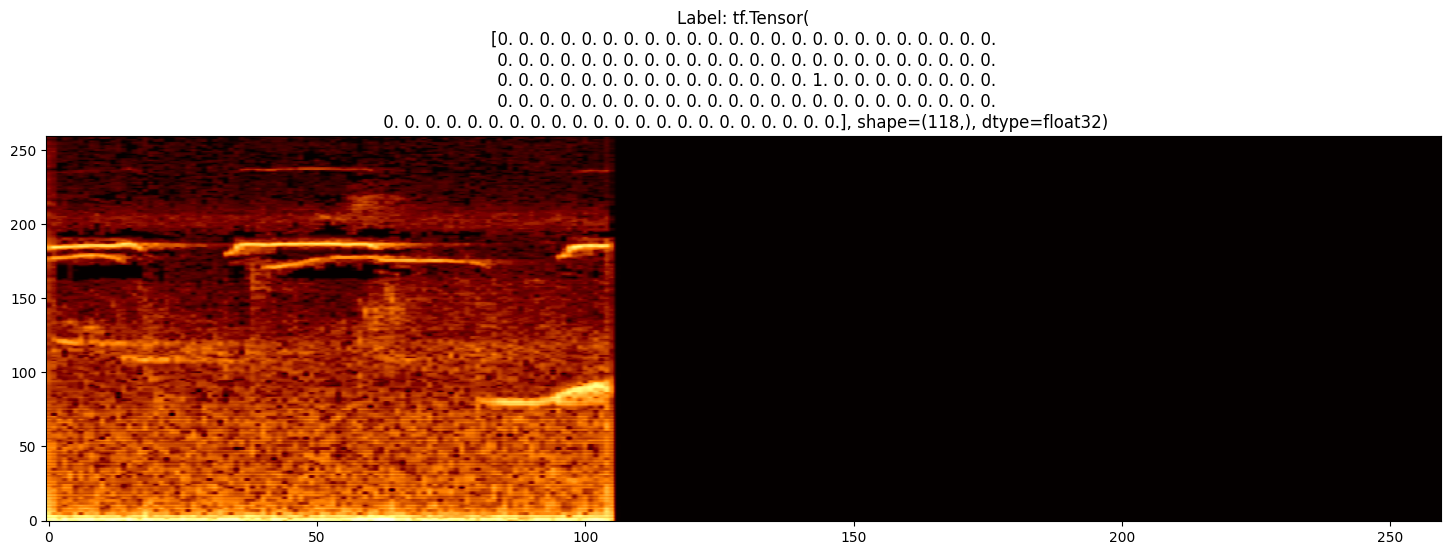

In [63]:
for melspectrogram,label in test_dataset.take(1):
    print(f' sample info: {melspectrogram.shape}, \n label info: {label.shape} \n {label}')
    for example in range(melspectrogram.shape[0]):
        plt.figure(figsize=(18,5))
        plt.imshow(melspectrogram[example,:,:,0].numpy().T, cmap='afmhot', origin='lower', aspect='auto')
        plt.title('Label: ' + str(label[example,:]))
        plt.show()

# Training non augmented data

In [25]:
# only run the code below if want to save the model
if not os.path.exists('models/'):
    os.mkdir('models/')
if not os.path.exists('models/2'):
    os.mkdir('models/2')   



## Building the Model
This model leverages pre-trained model weights for the EfficientNetV2 feature model which generates a vector representation of 1000 floats for each input image. The output from the EfficientNetV2 model is then fed into 2 fully connected layers to perform the classification function.

Note: new link to model: https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-classification/2

In [41]:
# Custom layer to wrap hub.KerasLayer
class HubLayer(tf.keras.layers.Layer):
    def __init__(self, hub_url, trainable=True):
        super(HubLayer, self).__init__()
        self.hub_layer = hub.KerasLayer(hub_url, trainable=trainable)

    def call(self, inputs):
        return self.hub_layer(inputs)

def build_model(trainable):
    # Build a classification model using a pre-trained EfficientNetV2
    model = tf.keras.Sequential(
        [
            # Input layer with specified image dimensions
            tf.keras.layers.InputLayer(input_shape=(dlc.SC['MODEL_INPUT_IMAGE_HEIGHT'], 
                                                    dlc.SC['MODEL_INPUT_IMAGE_WIDTH'], 
                                                    dlc.SC['MODEL_INPUT_IMAGE_CHANNELS'])),

            # Use the EfficientNetV2 model as a feature generator (needs 260x260x3 images)
            HubLayer("https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-classification/2", trainable),

            # Add the classification layers
            tf.keras.layers.Flatten(),
            tf.keras.layers.BatchNormalization(),

            # Fully connected layer with multiple of the number of classes
            tf.keras.layers.Dense(len(class_names) * 8,
                                  activation="relu"),
            tf.keras.layers.BatchNormalization(),

            # Another fully connected layer with multiple of the number of classes
            tf.keras.layers.Dense(len(class_names) * 4,
                                  activation="relu"),
            tf.keras.layers.BatchNormalization(),

            # Add dropout to reduce overfitting
            tf.keras.layers.Dropout(0.50),

            # Output layer with one node per class, without activation
            tf.keras.layers.Dense(len(class_names), activation=None),
        ]
    )
    # Set the input shape for the model
    model.build([None, 
                 dlc.SC['MODEL_INPUT_IMAGE_HEIGHT'],
                 dlc.SC['MODEL_INPUT_IMAGE_WIDTH'], 
                 dlc.SC['MODEL_INPUT_IMAGE_CHANNELS']])

    # Display the model summary
    model.summary()

    return model

In [43]:
# allow all the weights to be trained
model = build_model(True)


# the form_logits means the loss function has the 'softmax' buillt in.  This approach is numerically more stable
# than including the softmax activation on the last layer of the classifier
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              metrics=["accuracy"],
              )

# tensorboard for visualisation of results
log_dir = "tensorboard_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)

# reduce learning rate to avoid overshooting local minima
lr_reduce_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                      factor=0.75,
                                                      patience=8, 
                                                      verbose=1,
                                                      mode='min',
                                                      cooldown=0, 
                                                      min_lr=1e-7)

# end the training if no improvement for 16 epochs in a row, then restore best model weights
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=16,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

# save the best model as it trains..
mcp_save = tf.keras.callbacks.ModelCheckpoint('models/checkpoint_generic_model.keras', 
                                           save_best_only=True, 
                                           monitor='val_loss', 
                                           mode='min')

# any changes to the source code will generally require the disk cache to be cleared.
# So to be safe, the cache is cleared before training the model.  If you are sure
# the cache is still valid then comment out this code
# the first few epochs of the model training will be slow as the cache is populated with pipeline samples
# and will depend on the dataset size and the number of variants included
cache.clear()

# fit the model to the training set
# this may take 12-24 hours to run to full model convergence depending on your machine
model.fit(train_dataset, 
          validation_data=val_dataset,
          callbacks=[lr_reduce_plateau, early_stopping, tensorboard_callback, mcp_save],
          epochs=dlc.SC['MAX_EPOCHS'])      

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hub_layer_1 (HubLayer)          │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1000)           │         4,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 944)            │       944,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 944)            │         3,776 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 472)            │       446,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 472)            │         1,888 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 472)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 118)            │        55,814 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,456,462 (5.56 MB)

 Trainable params: 1,451,630 (5.54 MB)

 Non-trainable params: 4,832 (18.88 KB)

Epoch 1/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 319s 820ms/step - accuracy: 0.1391 - loss: 4.8510 - val_accuracy: 0.5263 - val_loss: 2.1582 - learning_rate: 1.0000e-04
Epoch 2/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 296s 784ms/step - accuracy: 0.4075 - loss: 2.8193 - val_accuracy: 0.6489 - val_loss: 1.5368 - learning_rate: 1.0000e-04
Epoch 3/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 277s 734ms/step - accuracy: 0.4939 - loss: 2.2454 - val_accuracy: 0.6973 - val_loss: 1.2839 - learning_rate: 1.0000e-04
Epoch 4/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 269s 712ms/step - accuracy: 0.5566 - loss: 1.9005 - val_accuracy: 0.7414 - val_loss: 1.0749 - learning_rate: 1.0000e-04
Epoch 5/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 261s 694ms/step - accuracy: 0.6014 - loss: 1.6764 - val_accuracy: 0.7751 - val_loss: 0.9086 - learning_rate: 1.0000e-04
Epoch 6/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 255s 676ms/step - accuracy: 0.6342 - loss: 1.5176 - val_accuracy: 0.8276 - val_loss: 0.7151 - learning_rate: 1.0000e-04
Epoch 7/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 

In [28]:
# Function to predict class and probability given a prediction
def predict_class(predictions):
    # Get the index of the class with the highest predicted probability
    predicted_index = int(tf.argmax(tf.squeeze(predictions)).numpy())
    # Get the class name using the predicted index
    predicted_class = class_names[predicted_index]
    # Calculate the predicted probability for the selected class
    predicted_probability = 100.0 * tf.nn.softmax(predictions)[predicted_index].numpy()
    # Round the probability to 2 decimal places
    predicted_probability = str(round(predicted_probability, 2))
    return predicted_class, predicted_probability

# Display class names and run prediction on test entries
print(f'Class names: {class_names}')
for features, labels in test_dataset:
    # Generate predictions for the given features
    predictions = model.predict(features, verbose=0)

    # Iterate over each item in the batch
    for batch_idx in range(predictions.shape[0]):
        # Get the index of the true class
        true_index = int(tf.argmax(tf.squeeze(labels[batch_idx])).numpy())
        # Get the true class name using the true index
        true_class = class_names[true_index]

        # Predict class and probability using the prediction function
        predicted_class, predicted_probability = predict_class(predictions[batch_idx])

        print(f'True class      : {true_class}')
        print(f'Predicted class : {predicted_class}')
        print(f'Predicted probability : {predicted_probability}')

Class names: ['Acanthiza chrysorrhoa', 'Acanthiza lineata', 'Acanthiza nana', 'Acanthiza pusilla', 'Acanthiza reguloides', 'Acanthiza uropygialis', 'Acanthorhynchus tenuirostris', 'Accipiter cirrocephalus', 'Aidemosyne modesta', 'Alauda arvensis', 'Anhinga novaehollandiae', 'Anthochaera phrygia', 'Antigone rubicunda', 'Artamus cinereus', 'Artamus cyanopterus', 'Artamus minor', 'Artamus superciliosus', 'Barnardius zonarius', 'Callocephalon fimbriatum', 'Calyptorhynchus banksii', 'Calyptorhynchus lathami', 'Capra Hircus', 'Carduelis carduelis', 'Carterornis leucotis', 'Cervus Unicolour', 'Ceyx azureus', 'Chenonetta jubata', 'Chlamydera nuchalis', 'Cincloramphus mathewsi', 'Cinclosoma punctatum', 'Cisticola exilis', 'Climacteris picumnus', 'Colluricincla harmonica', 'Conopophila albogularis', 'Cophixalus exiguus', 'Cophixalus infacetus', 'Cophixalus ornatus', 'Coracina novaehollandiae', 'Coracina papuensis', 'Corcorax melanorhamphos', 'Cormobates leucophaea', 'Corvus mellori', 'Coturnix p

In [53]:
# Save the full model for use with tensorflow serving
model.export('src/Prototypes/engine/Audio Augmentation Comparison/models/2/')

INFO:tensorflow:Assets written to: src/Prototypes/engine/Audio Augmentation Comparison/models/2/assets


INFO:tensorflow:Assets written to: src/Prototypes/engine/Audio Augmentation Comparison/models/2/assets


Saved artifact at 'src/Prototypes/engine/Audio Augmentation Comparison/models/2/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 260, 260, 3), dtype=tf.float32, name='keras_tensor_25')
Output Type:
  TensorSpec(shape=(None, 118), dtype=tf.float32, name=None)
Captures:
  1902654533904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1902654533552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1902654533200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1902654531792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1902654531440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1902654529680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1902654529328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1902654528976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1902654530384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1902654530032: TensorSpec(shape=(), dtype=tf.resourc

In [45]:
import tensorflow as tf
# Load the saved model
model_inference_layer = tf.keras.layers.TFSMLayer('C:/Users/regin/Documents/SIT374/new/Audio Augmentation Comparison/models/2/', call_endpoint='serving_default')

In [46]:
model_no = tf.keras.Sequential([
    model_inference_layer
])

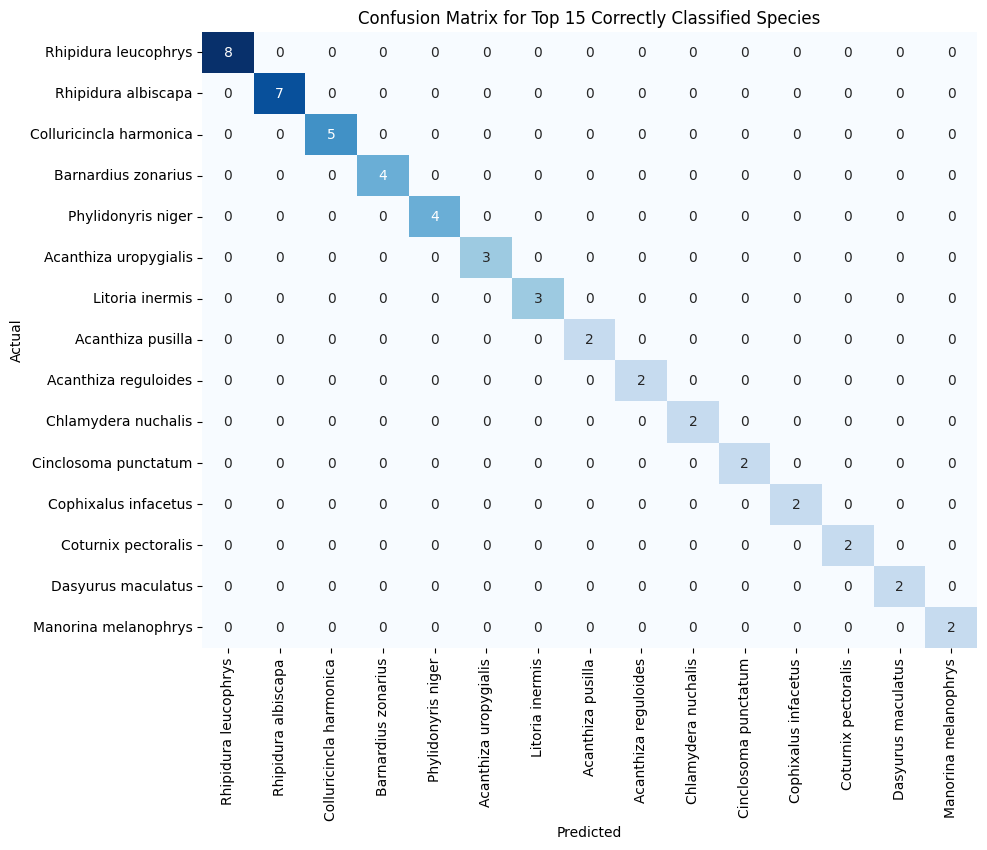

In [43]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Initialize dictionaries to store correct classifications for each class
correct_classifications = {species: 0 for species in class_names}

# Initialize empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Display class names and run prediction on test entries
for features, labels in test_dataset:
    # Generate predictions for the given features
    predictions_dict = model_no(features, training=False)  # TFSMLayer returns a dict
    predictions = predictions_dict['output_0'].numpy()  # Extract the actual predictions from the dict

    # Iterate over each item in the batch
    for batch_idx in range(predictions.shape[0]):
        # Get the index of the true class
        true_index = int(tf.argmax(tf.squeeze(labels[batch_idx])).numpy())
        true_class = class_names[true_index]

        # Predict class and probability using the prediction function
        predicted_class, _ = predict_class(predictions[batch_idx])

        # Append true and predicted labels to the respective lists
        true_labels.append(true_class)
        predicted_labels.append(predicted_class)

        # If the prediction is correct, increment the count for this species
        if predicted_class == true_class:
            correct_classifications[true_class] += 1

# Sort species by correct classifications in descending order and select the top 15
sorted_species = sorted(correct_classifications, key=correct_classifications.get, reverse=True)
top_15_species = sorted_species[:15]

# Ensure that both true and predicted labels are filtered consistently
filtered_true_labels = []
filtered_predicted_labels = []

for true_label, predicted_label in zip(true_labels, predicted_labels):
    if true_label in top_15_species and predicted_label in top_15_species:
        filtered_true_labels.append(true_label)
        filtered_predicted_labels.append(predicted_label)

# Calculate the confusion matrix for the top 15 species
conf_matrix = confusion_matrix(filtered_true_labels, filtered_predicted_labels, labels=top_15_species)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False,
            xticklabels=top_15_species, yticklabels=top_15_species)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Top 15 Correctly Classified Species")
plt.show()


In [47]:
import numpy as np
from collections import defaultdict

# Function to predict class and probability given a prediction
def predict_class(predictions):
    # Get the index of the class with the highest predicted probability
    predicted_index = int(tf.argmax(tf.squeeze(predictions)).numpy())
    # Get the class name using the predicted index
    predicted_class = class_names[predicted_index]
    # Calculate the predicted probability for the selected class
    predicted_probability = 100.0 * tf.nn.softmax(predictions)[predicted_index].numpy()
    return predicted_class, predicted_probability

# Initialize dictionaries to track correct and total predictions per class
correct_predictions = defaultdict(int)
total_predictions = defaultdict(int)

# Display class names and run prediction on test entries
print(f'Class names: {class_names}')
for features, labels in test_dataset:
    # Generate predictions for the given features
    predictions_dict = model_no(features, training=False)  # TFSMLayer returns a dict
    predictions = predictions_dict['output_0'].numpy()  # Extract the actual predictions from the dict


    # Iterate over each item in the batch
    for batch_idx in range(predictions.shape[0]):
        # Get the index of the true class
        true_index = int(tf.argmax(tf.squeeze(labels[batch_idx])).numpy())
        true_class = class_names[true_index]

        # Predict class and probability using the prediction function
        predicted_class, predicted_probability = predict_class(predictions[batch_idx])

        # Track the total number of predictions for this class
        total_predictions[true_class] += 1

        # Check if the prediction is correct
        if predicted_class == true_class:
            correct_predictions[true_class] += 1

# Calculate and print the average accuracy per class
print("\nAverage Accuracy for each class:")
for class_name in class_names:
    if total_predictions[class_name] > 0.00:
        accuracy = (correct_predictions[class_name] / total_predictions[class_name]) * 100
        print(f'{class_name}: {accuracy:.2f}%')



Class names: ['Acanthiza chrysorrhoa', 'Acanthiza lineata', 'Acanthiza nana', 'Acanthiza pusilla', 'Acanthiza reguloides', 'Acanthiza uropygialis', 'Acanthorhynchus tenuirostris', 'Accipiter cirrocephalus', 'Aidemosyne modesta', 'Alauda arvensis', 'Anhinga novaehollandiae', 'Anthochaera phrygia', 'Antigone rubicunda', 'Artamus cinereus', 'Artamus cyanopterus', 'Artamus minor', 'Artamus superciliosus', 'Barnardius zonarius', 'Callocephalon fimbriatum', 'Calyptorhynchus banksii', 'Calyptorhynchus lathami', 'Capra Hircus', 'Carduelis carduelis', 'Carterornis leucotis', 'Cervus Unicolour', 'Ceyx azureus', 'Chenonetta jubata', 'Chlamydera nuchalis', 'Cincloramphus mathewsi', 'Cinclosoma punctatum', 'Cisticola exilis', 'Climacteris picumnus', 'Colluricincla harmonica', 'Conopophila albogularis', 'Cophixalus exiguus', 'Cophixalus infacetus', 'Cophixalus ornatus', 'Coracina novaehollandiae', 'Coracina papuensis', 'Corcorax melanorhamphos', 'Cormobates leucophaea', 'Corvus mellori', 'Coturnix p

# Training Augmented Data

In [58]:
# only run the code below if want to save the model
if not os.path.exists('models/'):
    os.mkdir('models/')
if not os.path.exists('models/3'):
    os.mkdir('models/3')   



## Augmented Function

In [63]:
# Audio augmentation pipeline
def python_audio_augmentations(sample, label, variant, cache_key, cache_found):
    
    if cache_found == np.int32(0):
        # See https://github.com/iver56/audiomentations for more options
        augmentations = augs.Compose([
            # Add Gaussian noise with a random amplitude to the audio
            # This can help the model generalize to real-world scenarios where noise is present
            augs.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.2),

            # Time-stretch the audio without changing its pitch
            # This can help the model become invariant to small changes in the speed of the audio
            augs.TimeStretch(min_rate=0.8, max_rate=1.25, p=0.2),

            # Shift the pitch of the audio within a range of semitones
            # This can help the model generalize to variations in pitch that may occur in real-world scenarios
            augs.PitchShift(min_semitones=-4, max_semitones=4, p=0.2),

            # Shift the audio in time by a random fraction
            # This can help the model become invariant to the position of important features in the audio
            augs.Shift(min_shift=-0.5, max_shift=0.5, p=0.2),
        ])
        
        # apply audio augmentation to the clip
        # note: this augmentation is NOT applied in the test and validation pipelines
        sample = augmentations(samples=sample, sample_rate=dlc.SC['AUDIO_SAMPLE_RATE'])
    
    return sample, label, variant, cache_key, cache_found

## Update the training data

In [64]:
train_dataset_aug = (train_ds
                    .shuffle(len_train_ds)
                    .map(dlc.tensorflow_add_variant_and_cache, num_parallel_calls=parallel_calls)
                    .map(functools.partial(dlc.python_fuction_wrapper, dlc.python_disk_cache_start, cache_output_types), num_parallel_calls=parallel_calls)
                    .map(functools.partial(dlc.python_fuction_wrapper, dlc.python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
                    .map(dlc.tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
                    .map(functools.partial(dlc.python_fuction_wrapper, python_audio_augmentations, procs_output_types), num_parallel_calls=parallel_calls)
                    .map(functools.partial(dlc.python_fuction_wrapper, dlc.python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
                    .map(dlc.tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
                    # .map(tensorflow_image_augmentations, num_parallel_calls=parallel_calls)
                    .map(functools.partial(dlc.python_fuction_wrapper, dlc.python_disk_cache_end, procs_output_types), num_parallel_calls=parallel_calls)
                    .map(dlc.tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
                    .map(dlc.tensorflow_drop_variant_and_cache, num_parallel_calls=parallel_calls)
                    .batch(dlc.SC['CLASSIFIER_BATCH_SIZE'])
                    .prefetch(parallel_calls)
                    .repeat(count=1)
)

## Start Training

In [66]:
# allow all the weights to be trained
model_aug = build_model(True)


# the form_logits means the loss function has the 'softmax' buillt in.  This approach is numerically more stable
# than including the softmax activation on the last layer of the classifier
model_aug.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              metrics=["accuracy"],
              )

# tensorboard for visualisation of results
log_dir = "tensorboard_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)

# reduce learning rate to avoid overshooting local minima
lr_reduce_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                      factor=0.75,
                                                      patience=8, 
                                                      verbose=1,
                                                      mode='min',
                                                      cooldown=0, 
                                                      min_lr=1e-7)

# end the training if no improvement for 16 epochs in a row, then restore best model weights
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=16,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

# save the best model as it trains..
mcp_save = tf.keras.callbacks.ModelCheckpoint('models/checkpoint_generic_model2.keras', 
                                           save_best_only=True, 
                                           monitor='val_loss', 
                                           mode='min')

# any changes to the source code will generally require the disk cache to be cleared.
# So to be safe, the cache is cleared before training the model.  If you are sure
# the cache is still valid then comment out this code
# the first few epochs of the model training will be slow as the cache is populated with pipeline samples
# and will depend on the dataset size and the number of variants included
cache.clear()

# fit the model to the training set
# this may take 12-24 hours to run to full model convergence depending on your machine
model_aug.fit(train_dataset_aug, 
          validation_data=val_dataset,
          callbacks=[lr_reduce_plateau, early_stopping, tensorboard_callback, mcp_save],
          epochs=dlc.SC['MAX_EPOCHS'])      

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hub_layer_3 (HubLayer)          │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 1000)           │         4,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 944)            │       944,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 944)            │         3,776 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 472)            │       446,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 472)            │         1,888 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 472)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 118)            │        55,814 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,456,462 (5.56 MB)

 Trainable params: 1,451,630 (5.54 MB)

 Non-trainable params: 4,832 (18.88 KB)

Epoch 1/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.1313 - loss: 4.9374 - val_accuracy: 0.5319 - val_loss: 2.2579 - learning_rate: 1.0000e-04
Epoch 2/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 169s 448ms/step - accuracy: 0.3529 - loss: 3.1146 - val_accuracy: 0.6027 - val_loss: 1.7515 - learning_rate: 1.0000e-04
Epoch 3/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 168s 446ms/step - accuracy: 0.4657 - loss: 2.4711 - val_accuracy: 0.6938 - val_loss: 1.3210 - learning_rate: 1.0000e-04
Epoch 4/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 162s 430ms/step - accuracy: 0.5154 - loss: 2.1641 - val_accuracy: 0.7176 - val_loss: 1.1916 - learning_rate: 1.0000e-04
Epoch 5/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 157s 416ms/step - accuracy: 0.5591 - loss: 1.9305 - val_accuracy: 0.7652 - val_loss: 0.9875 - learning_rate: 1.0000e-04
Epoch 6/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 154s 408ms/step - accuracy: 0.5889 - loss: 1.7590 - val_accuracy: 0.7772 - val_loss: 0.8991 - learning_rate: 1.0000e-04
Epoch 7/30
376/376 ━━━━━━━━━━━━━━━━━━━━ 152

## Predictions

In [67]:
# Function to predict class and probability given a prediction
def predict_class(predictions):
    # Get the index of the class with the highest predicted probability
    predicted_index = int(tf.argmax(tf.squeeze(predictions)).numpy())
    # Get the class name using the predicted index
    predicted_class = class_names[predicted_index]
    # Calculate the predicted probability for the selected class
    predicted_probability = 100.0 * tf.nn.softmax(predictions)[predicted_index].numpy()
    # Round the probability to 2 decimal places
    predicted_probability = str(round(predicted_probability, 2))
    return predicted_class, predicted_probability

# Display class names and run prediction on test entries
print(f'Class names: {class_names}')
for features, labels in test_dataset:
    # Generate predictions for the given features
    predictions_aug = model_aug.predict(features, verbose=0)

    # Iterate over each item in the batch
    for batch_idx in range(predictions_aug.shape[0]):
        # Get the index of the true class
        true_index_aug = int(tf.argmax(tf.squeeze(labels[batch_idx])).numpy())
        # Get the true class name using the true index
        true_class_aug = class_names[true_index_aug]

        # Predict class and probability using the prediction function
        predicted_class_aug, predicted_probability_aug = predict_class(predictions_aug[batch_idx])

        print(f'True class      : {true_class_aug}')
        print(f'Predicted class : {predicted_class_aug}')
        print(f'Predicted probability : {predicted_probability_aug}')

Class names: ['Acanthiza chrysorrhoa', 'Acanthiza lineata', 'Acanthiza nana', 'Acanthiza pusilla', 'Acanthiza reguloides', 'Acanthiza uropygialis', 'Acanthorhynchus tenuirostris', 'Accipiter cirrocephalus', 'Aidemosyne modesta', 'Alauda arvensis', 'Anhinga novaehollandiae', 'Anthochaera phrygia', 'Antigone rubicunda', 'Artamus cinereus', 'Artamus cyanopterus', 'Artamus minor', 'Artamus superciliosus', 'Barnardius zonarius', 'Callocephalon fimbriatum', 'Calyptorhynchus banksii', 'Calyptorhynchus lathami', 'Capra Hircus', 'Carduelis carduelis', 'Carterornis leucotis', 'Cervus Unicolour', 'Ceyx azureus', 'Chenonetta jubata', 'Chlamydera nuchalis', 'Cincloramphus mathewsi', 'Cinclosoma punctatum', 'Cisticola exilis', 'Climacteris picumnus', 'Colluricincla harmonica', 'Conopophila albogularis', 'Cophixalus exiguus', 'Cophixalus infacetus', 'Cophixalus ornatus', 'Coracina novaehollandiae', 'Coracina papuensis', 'Corcorax melanorhamphos', 'Cormobates leucophaea', 'Corvus mellori', 'Coturnix p

In [ ]:
# Save the full model for use with tensorflow serving
model_aug.export('src/Prototypes/engine/Audio Augmentation Comparison/models/3/')

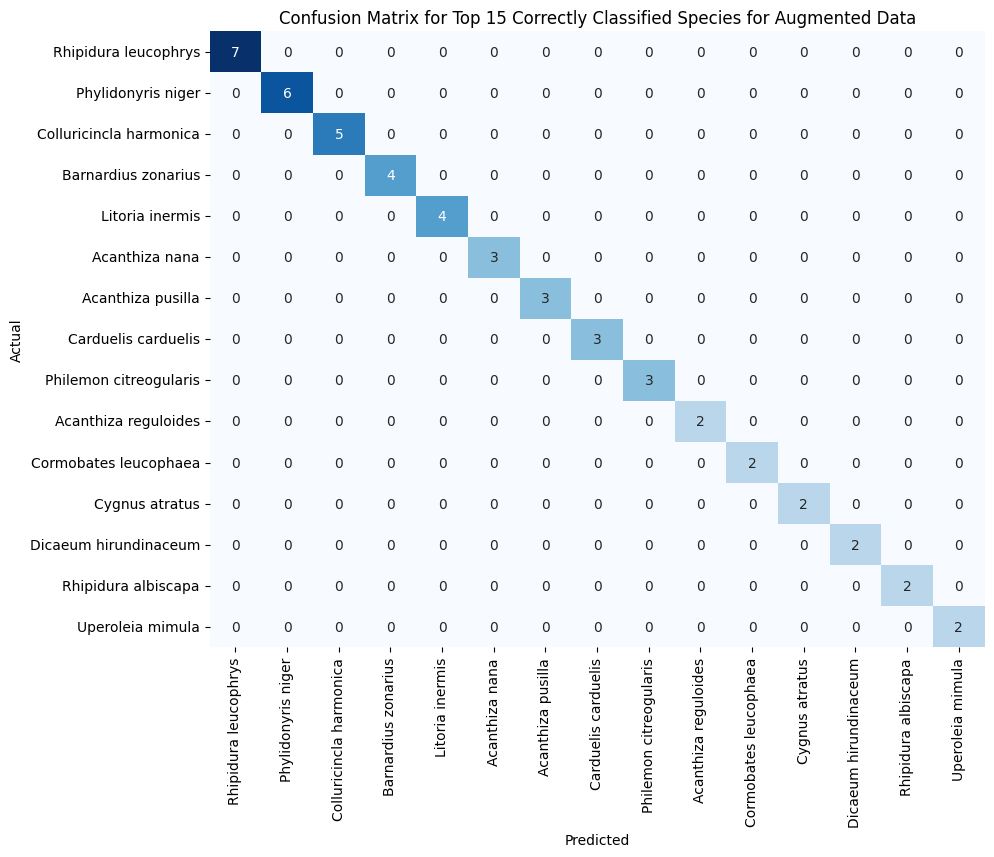

In [68]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Initialize dictionaries to store correct classifications for each class
correct_classifications_aug = {species: 0 for species in class_names}

# Initialize empty lists to store true labels and predicted labels
true_labels_aug = []
predicted_labels_aug = []

# Display class names and run prediction on test entries
for features, labels in test_dataset:
    # Generate predictions_aug for the given features
    predictions_aug = model_aug.predict(features, verbose=0)

    # Iterate over each item in the batch
    for batch_idx in range(predictions_aug.shape[0]):
        # Get the index of the true class
        true_index_aug = int(tf.argmax(tf.squeeze(labels[batch_idx])).numpy())
        true_class_aug = class_names[true_index_aug]

        # Predict class and probability using the prediction function
        predicted_class, _ = predict_class(predictions_aug[batch_idx])

        # Append true and predicted labels to the respective lists
        true_labels_aug.append(true_class_aug)
        predicted_labels_aug.append(predicted_class)

        # If the prediction is correct, increment the count for this species
        if predicted_class == true_class_aug:
            correct_classifications_aug[true_class_aug] += 1

# Sort species by correct classifications in descending order and select the top 15
sorted_species_aug = sorted(correct_classifications_aug, key=correct_classifications_aug.get, reverse=True)
top_15_species_aug = sorted_species_aug[:15]

# Ensure that both true and predicted labels are filtered consistently
filtered_true_labels_aug = []
filtered_predicted_labels_aug = []

for true_label, predicted_label in zip(true_labels_aug, predicted_labels_aug):
    if true_label in top_15_species_aug and predicted_label in top_15_species_aug:
        filtered_true_labels_aug.append(true_label)
        filtered_predicted_labels_aug.append(predicted_label)

# Calculate the confusion matrix for the top 15 species
conf_matrix_aug = confusion_matrix(filtered_true_labels_aug, filtered_predicted_labels_aug, labels=top_15_species_aug)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_aug, annot=True, cmap="Blues", fmt="d", cbar=False,
            xticklabels=top_15_species_aug, yticklabels=top_15_species_aug)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Top 15 Correctly Classified Species for Augmented Data")
plt.show()


In [56]:
import tensorflow as tf
# Load the saved model
model_inference_layer = tf.keras.layers.TFSMLayer('C:/Users/regin/Documents/SIT374/new/Audio Augmentation Comparison/models/2/', call_endpoint='serving_default')

model_aug = tf.keras.Sequential([
    model_inference_layer
])

In [59]:
import numpy as np
from collections import defaultdict

# Function to predict class and probability given a prediction
def predict_class(predictions):
    # Get the index of the class with the highest predicted probability
    predicted_index = int(tf.argmax(tf.squeeze(predictions)).numpy())
    # Get the class name using the predicted index
    predicted_class = class_names[predicted_index]
    # Calculate the predicted probability for the selected class
    predicted_probability = 100.0 * tf.nn.softmax(predictions)[predicted_index].numpy()
    return predicted_class, predicted_probability

# Initialize dictionaries to track correct and total predictions per class
correct_predictions = defaultdict(int)
total_predictions = defaultdict(int)

# Display class names and run prediction on test entries
print(f'Class names: {class_names}')
for features, labels in test_dataset:
    # Generate predictions for the given features
    predictions_dict = model_aug(features, training=False)  # TFSMLayer returns a dict
    predictions = predictions_dict['output_0'].numpy()  # Extract the actual predictions from the dict


    # Iterate over each item in the batch
    for batch_idx in range(predictions.shape[0]):
        # Get the index of the true class
        true_index = int(tf.argmax(tf.squeeze(labels[batch_idx])).numpy())
        true_class = class_names[true_index]

        # Predict class and probability using the prediction function
        predicted_class, predicted_probability = predict_class(predictions[batch_idx])

        # Track the total number of predictions for this class
        total_predictions[true_class] += 1

        # Check if the prediction is correct
        if predicted_class == true_class:
            correct_predictions[true_class] += 1

# Calculate and print the average accuracy per class
print("\nAverage Accuracy for each class:")
for class_name in class_names:
    if total_predictions[class_name] > 0.00:
        accuracy = (correct_predictions[class_name] / total_predictions[class_name]) * 100
        print(f'{class_name}: {accuracy:.2f}%')

Class names: ['Acanthiza chrysorrhoa', 'Acanthiza lineata', 'Acanthiza nana', 'Acanthiza pusilla', 'Acanthiza reguloides', 'Acanthiza uropygialis', 'Acanthorhynchus tenuirostris', 'Accipiter cirrocephalus', 'Aidemosyne modesta', 'Alauda arvensis', 'Anhinga novaehollandiae', 'Anthochaera phrygia', 'Antigone rubicunda', 'Artamus cinereus', 'Artamus cyanopterus', 'Artamus minor', 'Artamus superciliosus', 'Barnardius zonarius', 'Callocephalon fimbriatum', 'Calyptorhynchus banksii', 'Calyptorhynchus lathami', 'Capra Hircus', 'Carduelis carduelis', 'Carterornis leucotis', 'Cervus Unicolour', 'Ceyx azureus', 'Chenonetta jubata', 'Chlamydera nuchalis', 'Cincloramphus mathewsi', 'Cinclosoma punctatum', 'Cisticola exilis', 'Climacteris picumnus', 'Colluricincla harmonica', 'Conopophila albogularis', 'Cophixalus exiguus', 'Cophixalus infacetus', 'Cophixalus ornatus', 'Coracina novaehollandiae', 'Coracina papuensis', 'Corcorax melanorhamphos', 'Cormobates leucophaea', 'Corvus mellori', 'Coturnix p

In [58]:
predictions_aug

NameError: name 'predictions_aug' is not defined